<a href="https://colab.research.google.com/github/srinuvasb/download_sentienal_2_using_python/blob/main/final_output_task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install sentinelsat

In [ ]:
pip install rasterio

In [ ]:
pip install geopandas

In [ ]:
pip install numpy 

In [1]:
import folium
import numpy as np
import geopandas as gpd
from sentinelsat.sentinel import SentinelAPI,geojson_to_wkt,read_geojson
import rasterio 
import matplotlib.pyplot as plt
from rasterio import plot
from rasterio.plot import show
from rasterio.mask import mask
from osgeo import gdal
import requests
import json
import pandas as pd

In [6]:
def download_images(searcharea,user,password,date):
  # Search Area 
  search_area = gpd.read_file(searcharea)
  #Create a footprint of the region
  footprint = None
  for i in search_area['geometry']:
      footprint = i
  footprint
  # Filter data 
  api = SentinelAPI(user, password, 'https://scihub.copernicus.eu/dhus') 
  products = api.query(footprint,
                      date,
                      platformname='Sentinel-2',
                      processinglevel = 'Level-2A',
                      cloudcoverpercentage=(0, 5))
  #Create a GeoDataframe for the products and sort the queries on cloud cover percentage to fetch the scene with the lowest cloud cover
  gdf = api.to_geodataframe(products)
  gdf_sorted = gdf.sort_values(['cloudcoverpercentage'], ascending=[True])
  lowest_ccp = gdf_sorted['uuid'].iloc[0]
  api.download(lowest_ccp) # downloading datasets

In [7]:
searcharea=r'https://gist.githubusercontent.com/srinuvasb/a7d98682d8d11ec57f21d01ab8381c72/raw/5f9c649c037937a0cfaf9b94937d3bb56c647d2c/Adilabad.geojson'
user = 'srinuvasbathula09' 
password = 'Bathula123@'
date=('20220601', '20220831')

In [8]:
download_images(searcharea,user,password,date)

MD5 checksumming:   0%|          | 0.00/1.23G [00:00<?, ?B/s]

In [10]:
#Extract the data
import shutil
shutil.unpack_archive('/content/S2A_MSIL2A_20220607T050701_N0400_R019_T44QKF_20220607T093016.zip', '/content/drive/MyDrive/sentinel2_output')

In [11]:
R10 = '/content/drive/MyDrive/sentinel2_output/S2A_MSIL2A_20220607T050701_N0400_R019_T44QKF_20220607T093016.SAFE/GRANULE/L2A_T44QKF_A036338_20220607T051540/IMG_DATA/R10m/'

In [12]:
#Reading the file R,G,B, NIR images

b2blue = rasterio.open(R10+'T44QKF_20220607T050701_B02_10m.jp2') 
b3green = rasterio.open(R10+'T44QKF_20220607T050701_B03_10m.jp2') 
b4red = rasterio.open(R10+'T44QKF_20220607T050701_B04_10m.jp2')
band8 = rasterio.open(R10+'T44QKF_20220607T050701_B08_10m.jp2')


In [13]:
#Creating RGB
with rasterio.open('rgb_image.tiff','w',driver='Gtiff', width=b4red.width, height=b4red.height, 
              count=3,crs=b4red.crs,transform=b4red.transform, dtype=b4red.dtypes[0]) as rgb:
      rgb.write(b2blue.read(1),1) 
      rgb.write(b3green.read(1),2) 
      rgb.write(b4red.read(1),3) 
      rgb.close()

In [4]:
#RGB True color composite
rgbimage = rasterio.open(r'/content/rgb_image.tiff')
# Read the grid values into numpy arrays
red = rgbimage.read(3)
green = rgbimage.read(2)
blue = rgbimage.read(1)

# Function to normalize the grid values
def normalize(array):
    """Normalizes numpy arrays into scale 0.0 - 1.0"""
    array_min, array_max = array.min(), array.max()
    return ((array - array_min)/(array_max - array_min))

# Normalize the bands
redn = normalize(red)
greenn = normalize(green)
bluen = normalize(blue)

In [ ]:
# Create RGB natural color composite
rgb = np.dstack((redn, greenn, bluen))

# Let's see how our color composite looks like
plt.imshow(rgb)

In [ ]:
#False color composite
nir = rgbimage.read(4)
red = rgbimage.read(3)
green = rgbimage.read(2)

# Normalize the values using the function that we defined earlier
nirn = normalize(nir)
redn = normalize(red)
greenn = normalize(green)

# Create the composite by stacking
nrg = np.dstack((nirn, redn, greenn))

# Let's see how our color composite looks like
plt.imshow(nrg)

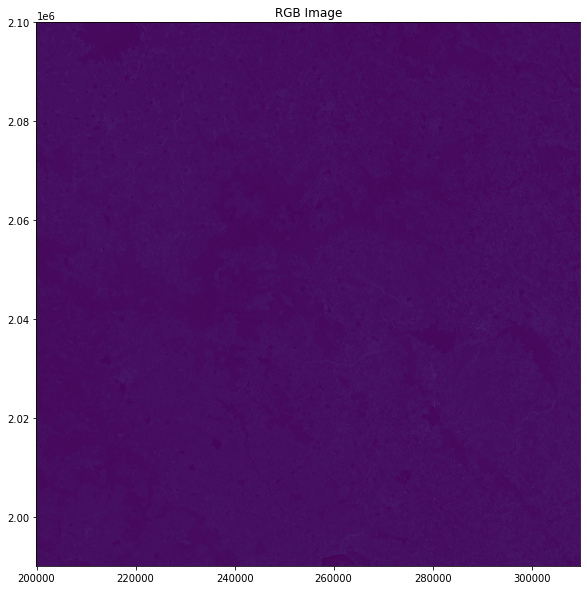

In [ ]:
src = rasterio.open(r'/content/rgb_image.tiff')
plt.figure(figsize=(10,10))
plt.title('RGB Image')
plot.show(src, adjust='linear')

In [ ]:
#creating masked image of our region of interest
def clip_raster(filname, AOI):
  bound_crs = AOI.to_crs({'init': 'epsg:32644'})
  with rasterio.open(filname) as src:
      out_image, out_transform = mask(src,
      bound_crs.geometry,crop=True)
      out_meta = src.meta.copy()
      out_meta.update({"driver": "GTiff",
                  "height": out_image.shape[1],
                  "width": out_image.shape[2],
                  "transform": out_transform})
      
  with rasterio.open("masked_image.tif", "w", **out_meta) as final:
      final.write(out_image)

In [ ]:
filname = r'/content/rgb_image.tiff'
AOI = gpd.read_file('/content/sample_data/Adilabad.geojson')

In [ ]:
clip_raster(filname, AOI)

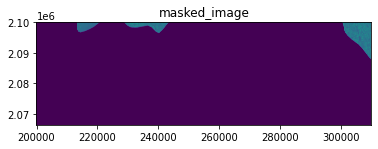

In [ ]:
#show masked image
src = rasterio.open(r'/content/masked_image.tif')
plt.figure(figsize=(6,6))
plt.title('masked_image')
plot.show(src, adjust='linear',transform=src.transform)

In [ ]:
def ndvi_calcul(b4, b8):
  # read Red(b4) and NIR(b8) as arrays
  red = b4.read()
  nir = b8.read()

  # Calculate ndvi
  ndvi = (nir.astype(float)-red.astype(float))/(nir+red)

  # Write the NDVI image
  meta = b4.meta # get the metadata of original GeoTIFF:
  meta.update(driver='GTiff')
  meta.update(dtype=rasterio.float32)

  with rasterio.open('NDVI.tif', 'w', **meta) as dst:
      dst.write(ndvi.astype(rasterio.float32))
  #stats on output NDVI
  print('\nMax NDVI: {m}'.format(m=ndvi.max()))
  print('Mean NDVI: {m}'.format(m=ndvi.mean()))
  print('Median NDVI: {m}'.format(m=np.median(ndvi)))
  print('Min NDVI: {m}'.format(m=ndvi.min()))


In [ ]:
b4 = rasterio.open(R10+'T44QKF_20220607T050701_B04_10m.jp2')
b8 = rasterio.open(R10+'T44QKF_20220607T050701_B08_10m.jp2')
ndvi_calcul(b4, b8)


Max NDVI: 0.6145409735058533
Mean NDVI: 0.15886077738105567
Median NDVI: 0.13649025069637882
Min NDVI: -0.2132276954874268


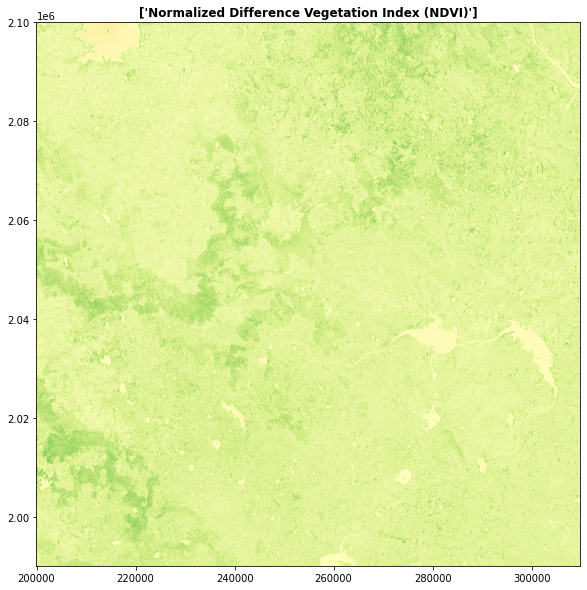

In [ ]:
#showing ndvi image
ndvi_image = rasterio.open(r'/content/NDVI.tif')
plt.figure(figsize=(10,10))
title = ["Normalized Difference Vegetation Index (NDVI)"]
plot.show(ndvi_image, cmap="RdYlGn",  title=title, vmin=-1, vmax=1)

In general, NDVI values range from -1.0 to 1.0, with negative values indicating clouds and water, positive values near zero indicating bare soil, and higher positive values of NDVI ranging from sparse vegetation (0.1 - 0.5) to dense green vegetation (0.6 and above).